# PROBLEM STATEMENT

Data assimilation are numerical methods used in geosciences to mix the information of observations (noted as $y$) and a dynamical model (noted as $f$) in order to estimate the true/hidden state of the system (noted as $x$) at every time step $k$. Usually, they are related following a nonlinear state-space model:
\begin{align}
  x_k & = f_{k-1,k}(x_{k-1}) + \eta_k\\
  y_k & = H x_k + \epsilon_k
\end{align}
with $\eta$ and $\epsilon$ some independant white Gaussian noises respectively respresenting the model forecast error and the error of observation. Specification and tuning of these errors are important issues in data assimilation. In this Python library, we propose an iterative expectation-maximisation (EM) algorithm to estimate the corresponding model error covariances, noted as $Q$ for the dynamical model and $R$ for the observations. We develop this EM algorithm using classical extended and ensemble versions of the Kalman smoother. We test the accuracy of the technic on different chaotic dynamical models, the Lorenz-63 and Lorenz-96 systems. 

This Python library is attached to the publication "Estimating model error covariances in nonlinear state-space models using Kalman smoothing and the expectation-maximisation algorithm", from **D. Dreano, P. Tandeo, M. Pulido, B. Ait-El-Fquih, T. Chonavel and I. Hoteit**, submitted to the *Quarterly Journal of the Royal Meteorological Society*. If you use this library, please do not forget to cite our work.

# IMPORT MODULES

Here, we import the different Python libraries and modules. Concerning the dynamical models, we provide two different implementations: a slow procedure in Python and a fast procedure in Fortran. In order to use the Fortran version, you need to compile the f90 files in the "models" folder ("l63_for.f90" and "l96_for.f90") using the command "f2py". You also need to download the "tqdm" library to display the progress bar (available at http://github.com/tqdm/).

In [1]:
%pylab inline
%matplotlib inline
pylab.rcParams['figure.figsize'] = (16, 9)

# numpy, matplotib and others
import numpy as np
from numpy.random import RandomState
from numpy.linalg import cholesky
import matplotlib.pyplot as plt
import os
import pickle

# L63 and L96 models using fortran (fast)
import models.l63f as mdl_l63
import models.l96f as mdl_l96

# L63 and L96 models using python (slow)
from models.L63 import l63_predict, l63_jac
from models.L96 import l96_predict, l96_f

# data assimilation routines
from algos.EM_EnKS import EnKS, EM_EnKS
from algos.EM_EKS import EKS, EM_EKS
from algos.utils import climat_background, RMSE, gen_truth, gen_obs

Populating the interactive namespace from numpy and matplotlib


# TEST ON LORENZ-63

To begin, as dynamical model $f$, we choose the Lorenz-63 chaotic system. This low-dimensional model is classicaly used in data assimilation and it is the one used in the publication by Dreano et al. cited below. We generate data using $Q=0.05 I_{3\times3}$ and $R=2 I_{3\times3}$. Then, we try to estimate these covariance matrices using the EM algorithm and two Kalman smoother procedures.

In [2]:
### GENERATE SIMULATED DATA (LORENZ-63 MODEL)

# random number generator
prng = RandomState(9)

# dynamical model
Nx = 3 # dimension of the state
dt = .01 # integration time
sigma = 10;rho = 28;beta = 8./3 # physical parameters
#f = lambda x: l63_predict(x, dt, sigma, rho, beta) # python version (slow)
fmdl=mdl_l63.M(sigma=sigma, rho=rho, beta=beta, dtcy=dt)
f = lambda x: fmdl.integ(x) # fortran version (fast)
jacF = lambda x: l63_jac(x, dt, sigma, rho, beta) # python version (slow)

# observation operator
No = 3 # dimension of the observations
h = lambda x: x
jacH = lambda x: np.eye(Nx)
H = np.eye(Nx)

# background state
x0_true = np.r_[6.39435776, 9.23172442, 19.15323224]
xb, B = climat_background(f, x0_true, 5000)

# size of the sequence
T = 1000 # 10 Lorenz-63 times
time = range(T)*array([dt])

# generate state
Q_true = np.eye(Nx) * .05
X_true = gen_truth(f, x0_true, T, Q_true, prng)

# generate observations
dt_obs = 5 # 1 observation every dt_obs time steps
R_true = np.eye(No) * 2
Yo = gen_obs(h, X_true, R_true, dt_obs, prng)

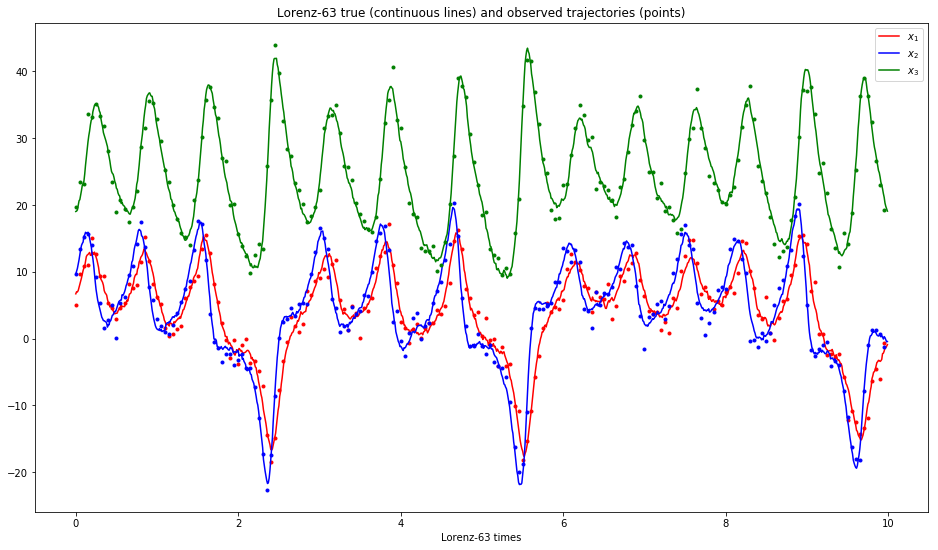

In [3]:
### PLOT STATE AND OBSERVATIONS

line1,=plt.plot(time,X_true[0,1:T+1],'-r');plt.plot(time,Yo[0,:],'.r')
line2,=plt.plot(time,X_true[1,1:T+1],'-b');plt.plot(time,Yo[1,:],'.b')
line3,=plt.plot(time,X_true[2,1:T+1],'-g');plt.plot(time,Yo[2,:],'.g')
plt.title('Lorenz-63 true (continuous lines) and observed trajectories (points)')
plt.xlabel('Lorenz-63 times')
plt.legend([line1, line2, line3], ['$x_1$', '$x_2$', '$x_3$'])

In [4]:
### INITIALIZE THE EM ALGORITHMS

# EM parameters
N_iter = 500
Q_init = np.eye(Nx)
R_init = np.eye(No)
N = 100 # number of members (only in EM-EnKS)

In [5]:
### APPLY THE EM ALGORITHM ON EXTENDED KALMAN SMOOTHER (EM-EKS)

# parameters
params = { 'initial_background_state'                 : xb,
           'initial_background_covariance'            : B,
           'initial_model_noise_covariance'           : Q_init,
           'initial_observation_noise_covariance'     : R_init,
           'model_dynamics'                           : f,
           'model_jacobian'                           : jacF,
           'observation_operator'                     : h,
           'observation_jacobian'                     : jacH,
           'observations'                             : Yo,
           'nb_EM_iterations'                         : N_iter,
           'true_state'                               : X_true,
           'state_size'                               : Nx,
           'observation_size'                         : No,
           'temporal_window_size'                     : T,
           'model_noise_covariance_structure'         : 'full',
           'is_model_noise_covariance_estimated'      : True,
           'is_observation_noise_covariance_estimated': True,
           'is_background_estimated'                  : True,
           'inflation_factor'                         : 1 }

# function
res_EM_EKS = EM_EKS(params)

100%|██████████| 500/500 [01:08<00:00,  7.31it/s]


In [6]:
### APPLY THE EM ALGORITHM ON ENSEMBLE KALMAN SMOOTHER (EM-EnKS)

# parameters
params = { 'initial_background_state'                 : xb,
           'initial_background_covariance'            : B,
           'initial_model_noise_covariance'           : Q_init,
           'initial_observation_noise_covariance'     : R_init,
           'model_dynamics'                           : f,
           'observation_matrix'                       : H,
           'observations'                             : Yo,
           'nb_particles'                             : N,
           'nb_EM_iterations'                         : N_iter,
           'true_state'                               : X_true,
           'inflation_factor'                         : 1,
           'temporal_window_size'                     : T,
           'state_size'                               : Nx,
           'observation_size'                         : No,
           'is_model_noise_covariance_estimated'      : True,
           'is_observation_noise_covariance_estimated': True,
           'is_background_estimated'                  : True,
           'model_noise_covariance_structure'         : 'full'}

# function
res_EM_EnKS = EM_EnKS(params, prng)

100%|██████████| 500/500 [03:09<00:00,  2.64it/s]


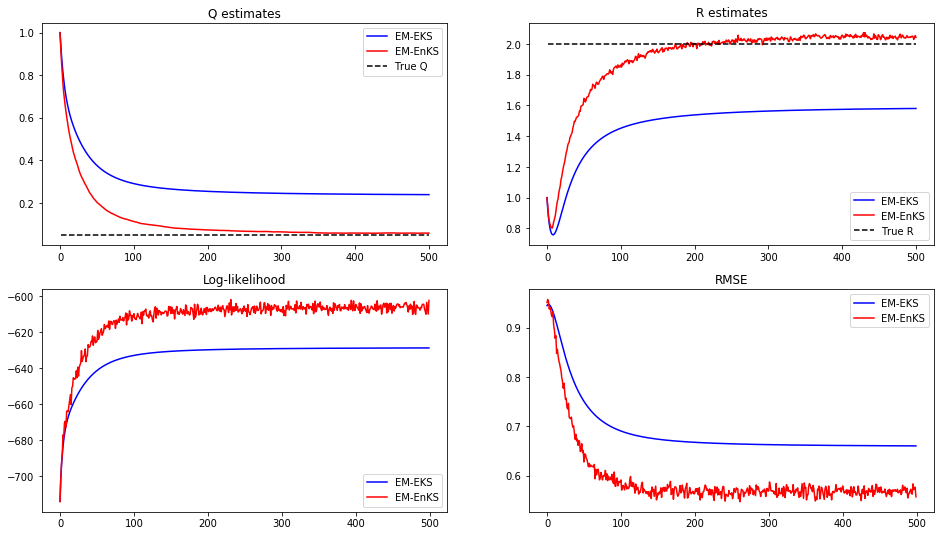

In [7]:
### COMPARE RESULTS BETWEEN THE TWO STRATEGIES (EM-EKS AND EM-EnKS)

# extract outputs
Q_EKS = res_EM_EKS['EM_model_noise_covariance']
Q_EnKS = res_EM_EnKS['EM_model_noise_covariance']
R_EKS = res_EM_EKS['EM_observation_noise_covariance']
R_EnKS = res_EM_EnKS['EM_observation_noise_covariance']
loglik_EKS=res_EM_EKS['loglikelihood']
loglik_EnKS=res_EM_EnKS['loglikelihood']
RMSE_EKS=res_EM_EKS['RMSE']
RMSE_EnKS=res_EM_EnKS['RMSE']

# plot trace of Q
plt.subplot(2,2,1)
line1,=plt.plot(np.trace(Q_EKS)/Nx,'b')
line2,=plt.plot(np.trace(Q_EnKS)/Nx,'r')
line3,=plt.plot((1,N_iter),(np.trace(Q_true)/Nx,np.trace(Q_true)/Nx),'--k')
plt.title('Q estimates')
plt.legend([line1, line2, line3], ['EM-EKS', 'EM-EnKS', 'True Q'])

# plot trace of R
plt.subplot(2,2,2)
line1,=plt.plot(np.trace(R_EKS)/No,'b')
line2,=plt.plot(np.trace(R_EnKS)/No,'r')
line3,=plt.plot((1,N_iter),(np.trace(R_true)/No,np.trace(R_true)/No),'--k')
plt.title('R estimates')
plt.legend([line1, line2, line3], ['EM-EKS', 'EM-EnKS', 'True R'])

# plot log-likelihood
plt.subplot(2,2,3)
line1,=plt.plot(loglik_EKS,'b')
line2,=plt.plot(loglik_EnKS,'r')
plt.title('Log-likelihood')
plt.legend([line1, line2], ['EM-EKS', 'EM-EnKS'])

# plot Root Mean Square Error
plt.subplot(2,2,4)
line1,=plt.plot(RMSE_EKS,'b')
line2,=plt.plot(RMSE_EnKS,'r')
plt.title('RMSE')
plt.legend([line1, line2], ['EM-EKS', 'EM-EnKS'])

The results show that the Ensemble Kalman Smoother version (EM-EnKS) almost convergences to the true values of the Q and R matrices. Note that we can improve the performance using a larger number of members $N$. The Extended Kalman Smoother results (EM-EKS) are bad due to the large time step between consecutive observations $dt_{obs}$.   

# TEST ON LORENZ-96

In this Python library, you can easily use your own dynamical model $f$, adding it in the "models" folder. Here, we perform an experiment with the 40-dimensional Lorenz-96 dynamical model. We generate data using $Q=0.1 I_{40\times40}$ and $R=2 I_{40\times40}$. Then, we try to estimate these covariance matrices using the EM-EnKS with $N=100$ members.

In [8]:
### GENERATE SIMULATED DATA (LORENZ 96 MODEL)

# random number generator
prng = RandomState(1)

# dynamical model
Nx = 40 # dimension of the state
dt = .05 # integration time
F = 8 # physical parameter
# f = lambda x: l96_predict(x,dt,F) # python version (slow)
fmdl=mdl_l96.M(dtcy=dt, force=F, nx=Nx)
f = lambda x: fmdl.integ(x) # fortran version (fast)

# observation operator
No = 40 # dimension of the observations
h = lambda x: x
jacH = lambda x: np.eye(Nx)
H = np.eye(Nx)

# background state
x0_true = array(zeros(Nx))
xb, B = climat_background(f, x0_true, 5000)

# size of the sequence
T = 400 # 20 Lorenz-96 times
time = range(T+1)*array([dt])

# generate state
Q_true = np.eye(Nx) * .1
X_true = gen_truth(f, x0_true, T+50, Q_true, prng)

# generate observations
dt_obs = 2 # 1 observation every dt_obs time steps
R_true = np.eye(No) * 2
Yo = gen_obs(h, X_true, R_true, dt_obs, prng)

# remove first part of the sequence (time to converge to the attractor)
X_true = X_true[:,50:T+50+1]
Yo = Yo[:,50:T+50+1]

Text(0.5,1,'Observed trajectories')

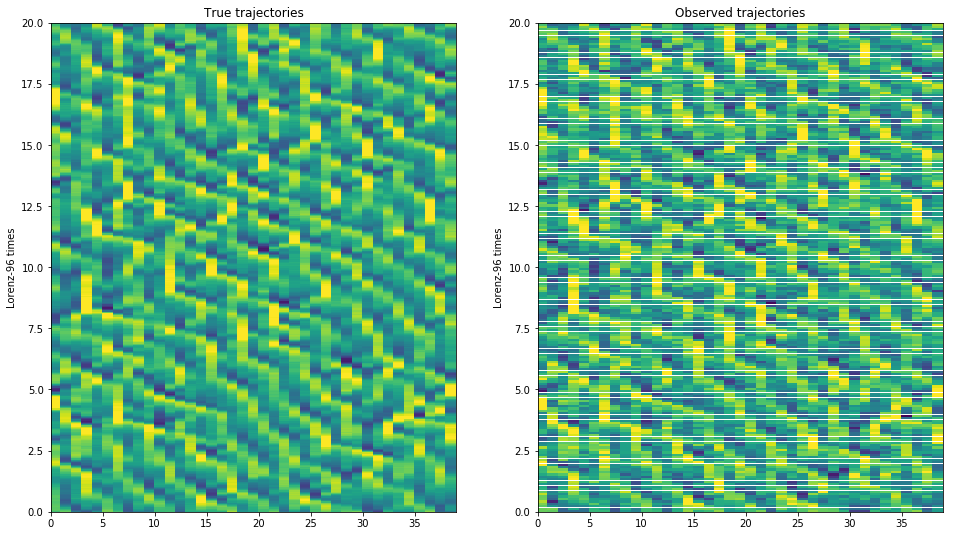

In [9]:
### PLOT STATE AND OBSERVATIONS

[X,Y]=meshgrid(range(Nx),time)
subplot(1,2,1);pcolor(X,Y,X_true.T);xlim([0,Nx-1]);clim([-10,10]);ylabel('Lorenz-96 times');title('True trajectories')
subplot(1,2,2);pcolor(X,Y,ma.masked_where(isnan(Yo.T),Yo.T));xlim([0,Nx-1]);clim([-10,10]);ylabel('Lorenz-96 times');title('Observed trajectories')

In [10]:
### APPLY THE EM ALGORITHM ON ENSEMBLE KALMAN SMOOTHER (EM-EnKS)

# EM parameters
N_iter = 50
Q_init = np.eye(Nx)
R_init = np.eye(No)
N = 100 # number of members

# parameters
params = { 'initial_background_state'                 : xb,
           'initial_background_covariance'            : B,
           'initial_model_noise_covariance'           : Q_init,
           'initial_observation_noise_covariance'     : R_init,
           'model_dynamics'                           : f,
           'observation_matrix'                       : H,
           'observations'                             : Yo,
           'nb_particles'                             : N,
           'nb_EM_iterations'                         : N_iter,
           'true_state'                               : X_true,
           'inflation_factor'                         : 1,
           'temporal_window_size'                     : T,
           'state_size'                               : Nx,
           'observation_size'                         : No,
           'is_model_noise_covariance_estimated'      : True,
           'is_observation_noise_covariance_estimated': True,
           'is_background_estimated'                  : True,
           'model_noise_covariance_structure'         : 'full',
           #'model_noise_covariance_matrix_template'   : np.eye(Nx) # only for constant model noise covariance
         }

# function
res_EM_EnKS = EM_EnKS(params, prng)

100%|██████████| 50/50 [01:52<00:00,  2.24s/it]


Text(0.5,1,'RMSE')

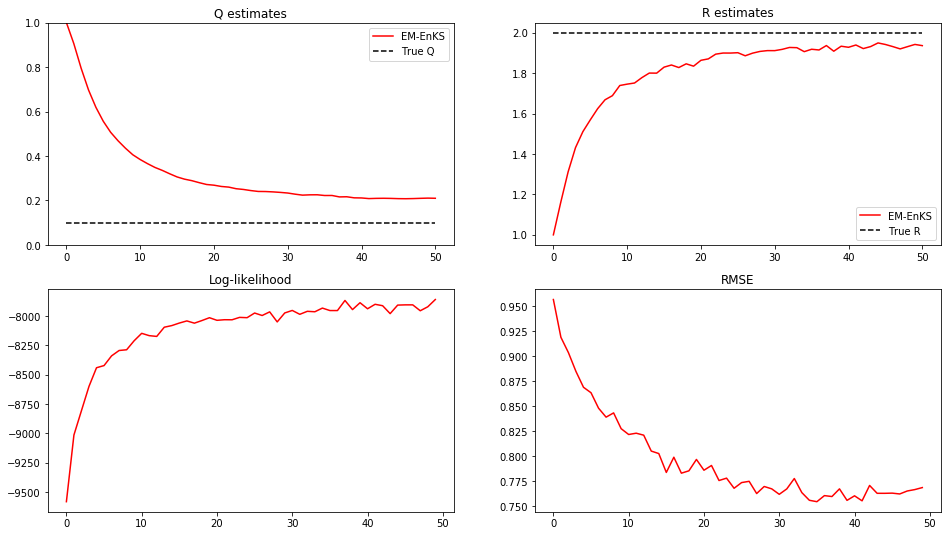

In [11]:
### PLOT RESULTS OF EM-EnKS

# extract outputs
Q_EnKS = res_EM_EnKS['EM_model_noise_covariance']
R_EnKS = res_EM_EnKS['EM_observation_noise_covariance']
loglik_EnKS=res_EM_EnKS['loglikelihood']
RMSE_EnKS=res_EM_EnKS['RMSE']
Xs=res_EM_EnKS['smoothed_ensemble']

# plot trace of Q
plt.subplot(2,2,1)
line2,=plt.plot(np.trace(Q_EnKS)/Nx,'r')
line3,=plt.plot((0,N_iter),(np.trace(Q_true)/Nx,np.trace(Q_true)/Nx),'--k')
plt.title('Q estimates')
ylim([0,1])
plt.legend([line2, line3], ['EM-EnKS', 'True Q'])

# plot trace of R
plt.subplot(2,2,2)
line2,=plt.plot(np.trace(R_EnKS)/No,'r')
line3,=plt.plot((0,N_iter),(np.trace(R_true)/No,np.trace(R_true)/No),'--k')
plt.title('R estimates')
plt.legend([line2, line3], ['EM-EnKS', 'True R'])

# plot log-likelihood
plt.subplot(2,2,3)
plt.plot(loglik_EnKS,'r')
plt.title('Log-likelihood')

# plot Root Mean Square Error
plt.subplot(2,2,4)
plt.plot(RMSE_EnKS,'r')
plt.title('RMSE')

The results show that the EM-EnKS with $N=100$ almost convergences to the true values of the Q and R matrices. To improve the results, you need to increase the size of the sequence (e.g., use $T=1000$ corresponding to 50 Lorenz-96 times).